In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import multiprocessing
import os
import matplotlib.pyplot as plt
import numpy as np
import skopt
import xlearn as xl
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)
from skopt.plots import (plot_convergence, plot_evaluations, plot_objective)
from utils.measuring_performance import *
from utils.misc import *

/Users/a406127/anaconda3/envs/ctr_prediction/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
DATA_DIR = os.path.abspath('../../Data/display_advertising_challenge/processed')
MODEL_DIR = os.path.abspath('models')
USE_FIELD = True

In [4]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [5]:
model_type = 'ffm' if USE_FIELD else 'fm'
train_dataset_type = 'train'
test_dataset_type = 'valid'

train_dataset_path = os.path.join(DATA_DIR, '_'.join([model_type, 'dataset', train_dataset_type]) + '.libsvm')
test_dataset_path = os.path.join(DATA_DIR, '_'.join([model_type, 'dataset', test_dataset_type]) + '.libsvm')
model_path = os.path.join(MODEL_DIR, '_'.join([model_type, 'model', train_dataset_type]) + '.out')
score_path = os.path.join(MODEL_DIR, '_'.join([model_type, 'score', test_dataset_type]) + '.txt')

In [6]:
model = xl.create_ffm() if USE_FIELD else xl.create_fm()
model.setOnDisk()
model.setSigmoid()
model.setTrain(train_dataset_path)
model.setValidate(test_dataset_path)
model.setTest(test_dataset_path)

In [7]:
def update_params(params):
    default_params = {
        'task': 'binary'
        , 'nthread': int(0.5 * multiprocessing.cpu_count())
        , 'opt': 'adagrad' 
        , 'epoch': 100
        , 'stop_window': 3
        , 'metric': 'auc'
    }
    default_params.update(params)
    return default_params


def set_args(model, space, model_path, score_path, y_true):
    @skopt.utils.use_named_args(space)
    def _objective(**params):
        params = update_params(params)
        model.fit(params, model_path)
        model.predict(model_path, score_path)
        with open(score_path, 'r') as file:
            y_score = np.array([float(line) for line in file])
        return -1.0 * roc_auc_score(y_true, y_score)
    return _objective

In [8]:
with open(test_dataset_path, 'r') as file:
    y_true = np.array([int(line[0]) for line in file])

In [9]:
space = [skopt.space.Real(0.0125, 0.4, name='lr', prior='log-uniform'), 
         skopt.space.Real(0.0005, 0.016, name='lambda', prior='log-uniform'), 
         skopt.space.Integer(2, 4, name='k')]

objective = set_args(model, space, model_path, score_path, y_true)

In [10]:
with get_elapsed_time():
    results = skopt.forest_minimize(objective, space, base_estimator='ET', acq_func='EI', n_calls=30, 
                                    random_state=42, verbose=False, xi=0.01, n_jobs=1)

In [11]:
skopt.dump(results, os.path.join(MODEL_DIR, '_'.join([model_type, 'param', train_dataset_type]) + '.pkl'), 
           store_objective=False)

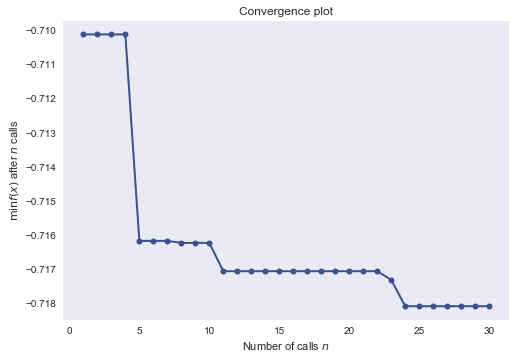

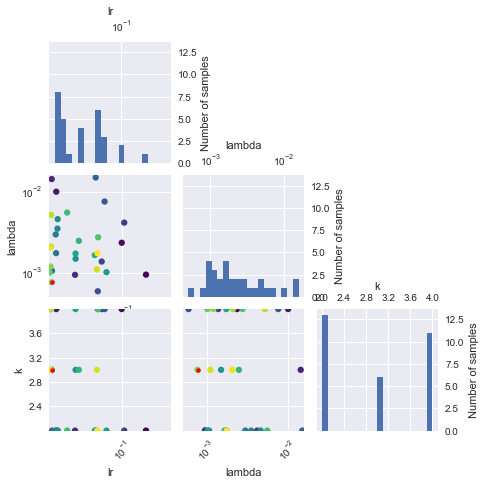

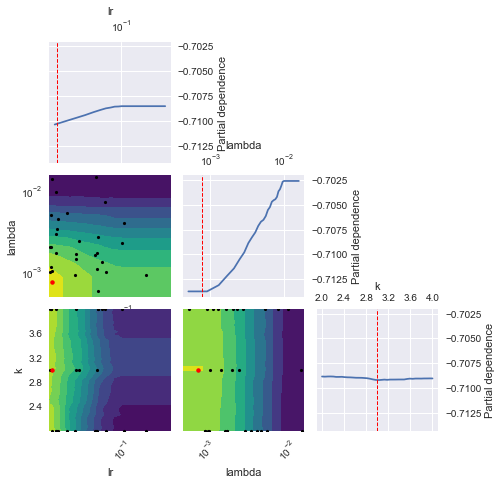

In [12]:
_ = skopt.plots.plot_convergence(results)
_ = skopt.plots.plot_evaluations(results)
_ = skopt.plots.plot_objective(results)

In [13]:
results = skopt.load(os.path.join(MODEL_DIR, '_'.join([model_type, 'param', train_dataset_type]) + '.pkl'))

train_dataset_type = 'train+valid'
test_dataset_type = 'test'

train_dataset_path = os.path.join(DATA_DIR, '_'.join([model_type, 'dataset', train_dataset_type]) + '.libsvm')
test_dataset_path = os.path.join(DATA_DIR, '_'.join([model_type, 'dataset', test_dataset_type]) + '.libsvm')
model_path = os.path.join(MODEL_DIR, '_'.join([model_type, 'model', train_dataset_type]) + '.out')
score_path = os.path.join(MODEL_DIR, '_'.join([model_type, 'score', test_dataset_type]) + '.txt')

In [14]:
model.setTrain(train_dataset_path)
model.setValidate(test_dataset_path)
model.setTest(test_dataset_path)

In [15]:
with open(test_dataset_path, 'r') as file:
    y_true = np.array([int(line[0]) for line in file])

In [16]:
with get_elapsed_time():
    model.fit(update_params({k: v for k, v in zip(['lr', 'lambda', 'k'], results.x)}), model_path)
    model.predict(model_path, score_path)

Elapsed time: 4455 sec


In [17]:
with open(score_path, 'r') as file:
    y_score = np.array([float(line) for line in file])

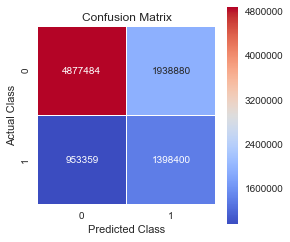

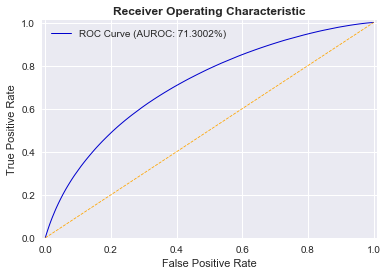

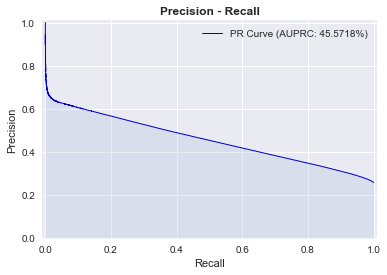

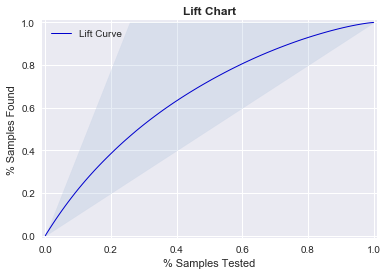

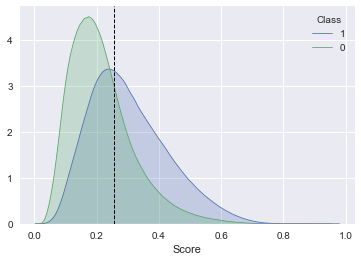

In [18]:
ctr = y_true.mean()
y_pred = get_y_pred(y_score, threshold=ctr)

norm_entropy = get_norm_entropy(y_true, y_score)
calibration = y_score.mean() / ctr
accuracy, precision, recall, f1 = accuracy_score(y_true, y_pred), precision_score(y_true, y_pred), \
    recall_score(y_true, y_pred), f1_score(y_true, y_pred)

confusion_matrix = plot_confusion_matrix(y_true, y_pred)
auroc = plot_roc_curve(y_true, y_score)
auprc = plot_pr_curve(y_true, y_score)
_ = plot_lift_curve(y_true, y_score)
_ = plot_class_density(y_true, y_score, threshold=ctr)

In [19]:
dump_pickle(os.path.join(MODEL_DIR, '_'.join([model_type, 'metric', train_dataset_type]) + '.pkl'), 
            (norm_entropy, calibration, accuracy, precision, recall, f1, confusion_matrix, auroc, auprc))

In [20]:
test_dataset_type = 'quiz'
test_dataset_path = os.path.join(DATA_DIR, '_'.join([model_type, 'dataset', test_dataset_type]) + '.libsvm')
score_path = os.path.join(MODEL_DIR, '_'.join([model_type, 'score', test_dataset_type]) + '.txt')

In [21]:
model.setTest(test_dataset_path)
with get_elapsed_time():
    model.predict(model_path, score_path)